# [Insert Creative Title HERE]

## Introduction and Motivation

## Required Libraries

Intro to Pandas:
https://pandas.pydata.org/pandas-docs/version/0.15/tutorials.html

Learning the Spotify API through spotipy:
https://spotipy.readthedocs.io/en/latest/#


In [270]:
import sys
import pandas as pd
import numpy as np
import spotipy
import spotipy.util as util
import matplotlib.pyplot as plt
from sklearn import cluster, decomposition, metrics
import plotly.graph_objects as go
import seaborn

## Data Collection and Tidying
//TODO Talk about general authentication flow.<br>
//TODO Link example resource. <br>
//TODO Explain how to get the spotify username<br>
//TODO talk about how we chose what columns to keep. Talk about how data is relatively simple and no need to reorganize

In [167]:
# Generate authorization token for reading user library
username = '12124976904'

scope = 'user-library-read playlist-modify-public'
client_id = '076ff5215a374d2481d0117877d79b74'
client_secret = '0ff2fd29106e4b7ebd7da4152d4a20c3'
redirect_uri = 'https://www.google.com/'

token = util.prompt_for_user_token(username, scope, client_id, client_secret, redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)

else:
    print("Can't get token for", username)
    sys.exit()



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=076ff5215a374d2481d0117877d79b74&response_type=code&redirect_uri=https%3A%2F%2Fwww.google.com%2F&scope=playlist-modify-public+user-library-read in your browser


Enter the URL you were redirected to: https://www.google.com/?code=AQDcj7TriW5jYCtduVlaEQVFVm0uC6FVNWUjH2ZdrI4BHfikKLpH2w01i6W8l4VfkT7O8ElZ33anaq-Qk93ln_31JEvg75epL9YRU5Q3sLUBdNMoBOy8vSGBM0Jqhx8K5Tr46VQjulXAckkFKPjTGDT4EQwgje7RXIDavwoL1wWXOArWYHF45_Q-DqOxbidRrun9IBuCdcrMD8Y_RaTXRXVFMdFa1n3p1QulmmEGNfC3Poic3pGo-g




//TODO explain the code flow <br>
//TODO talk about how we chose what columns to keep. <br>
//TODO Talk about how data is relatively simple and no need to reorganize <br>

In [82]:
def get_saved_tracks():
    results = sp.current_user_saved_tracks()
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

print('Loading Saved Tracks Now. Please be patient!')

if True:
    tracks = get_saved_tracks()
    features = []
    track_info = []
    artist_uris = {}
    
    for track in tracks:
        track = track['track']
        features.extend(sp.audio_features(track['uri']))
        track_info.append([track['name'], track['artists'][0]['name']])
        artist_uris[track['artists'][0]['name']] = track['artists'][0]['uri']

    features = pd.DataFrame(features)
    track_info = pd.DataFrame(track_info).rename(columns={0: "title", 1: "artist"})

    features = features[['acousticness', 'danceability', 'energy', 'instrumentalness', 'tempo', 'valence']]
    features['tempo'] = (features['tempo']-features['tempo'].min())/(features['tempo'].max()-features['tempo'].min())

else:
    features = pd.read_csv('sample_data') #TODO download the dataframe as a csv and add to path
    
features

Loading Saved Tracks Now. Please be patient!


,acousticness,danceability,energy,instrumentalness,tempo,valence
0,0.847000,0.342,0.352,0.899,0.280701,0.0371
1,0.872000,0.318,0.590,0.911,0.404077,0.0317
2,0.815000,0.527,0.332,0.506,0.360837,0.0362
3,0.521000,0.619,0.606,0.541,0.532921,0.4210
4,0.635000,0.544,0.512,0.595,0.471877,0.3600
...,...,...,...,...,...,...
93,0.000018,0.312,0.794,0.361,0.550520,0.4270
94,0.132000,0.536,0.693,0.557,0.477839,0.5360
95,0.000079,0.396,0.760,0.243,0.481419,0.1940
96,0.003340,0.153,0.556,0.880,0.298057,0.0373


## Exploratory Data Analysis & Visualizations

In [ ]:
#Explain the columns and how values are determined.
# Summary Statistics
# Histograms
# Correlation Graphs

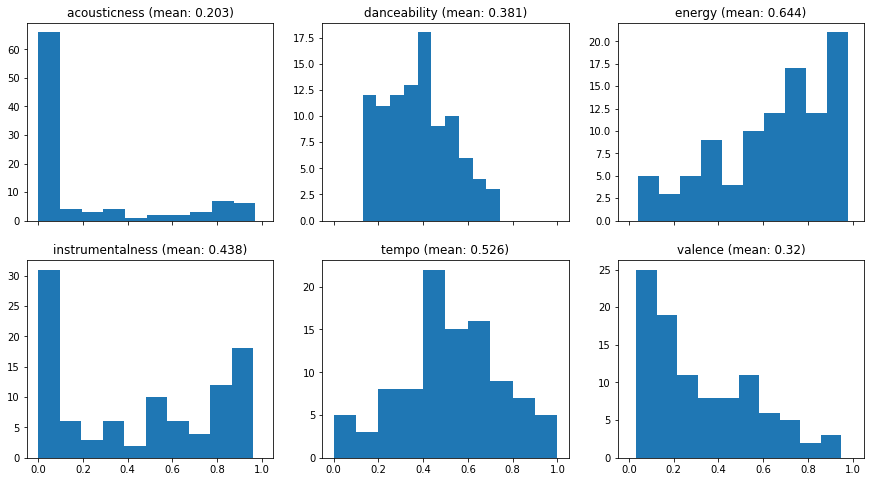

In [19]:
fig, ax = plt.subplots(2, 3, sharex=True, figsize=(15,8))
ax = ax.flatten()
idx = 0

for col in features.columns:
    ax[idx].hist(features[col])
    ax[idx].set_title(col + " (mean: " + str(np.round(features[col].mean(), 3)) + ")")
    idx += 1

## Machine Learning

In [ ]:
# Found cool article on PCA & One Class SVM here:
# https://medium.com/cuepoint/visualizing-hundreds-of-my-favorite-songs-on-spotify-fe50c94b8af3
# Implementation is found here:
# http://www.esparsons.com/blogmain/2018/11/27/an-eclectic-spotify-library-visualized-with-chartify

#TODO One Class SVM
#TODO Clustering: Model selection (affinity propagation, mean shift, agglomerative clustering - davies-bouldin index)
#TODO get top songs from similar artists, match them to clusters, find closest matching songs with silhouette score,
#create playlists
#TODO EDA for the individual playlists (highlighting common features between library songs and recommended songs)

#TODO Error analysis...
#TODO Check if new playlists can fit into the SVM

### Clustering & Principal Component Analysis

In [289]:
affinity = cluster.AffinityPropagation(preference=0).fit(features.values)
pref = 0
db_scores = {}

while (len(affinity.cluster_centers_) > 6):
    pref -= 1
    affinity = cluster.AffinityPropagation(preference=pref).fit(features.values)
    
    if len(affinity.cluster_centers_) <= 10 and len(affinity.cluster_centers_) >= 6:
        db_scores[metrics.davies_bouldin_score(features.values, affinity.labels_)] = affinity
    
db_scores

{0.5222932707795389: AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
                     damping=0.5, max_iter=200, preference=-13, verbose=False),
 0.569877878070865: AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
                     damping=0.5, max_iter=200, preference=-16, verbose=False)}

In [290]:
clusters = db_scores[min(db_scores.keys())]
features['Cluster'] = clusters.labels_
track_info['Cluster'] = clusters.labels_
track_info.iloc[clusters.cluster_centers_indices_]

,title,artist,Cluster
10,Lip - Like Mountains,Eric Shoves Them in His Pockets,0
20,30 Equals,Sleepytime Trio,1
24,Heroine,Malady,2
32,Rising Moisture,Sparkling Wide Pressure,3
59,Heat,Tigers Jaw,4
61,Talk,Coldplay,5
63,Breakaway Terminal Cable,Cerberus Shoal,6
88,Treachery,Unwound,7


In [291]:
#Can play with this to see the songs in each cluster
track_info.loc[track_info['Cluster'] == 0]

,title,artist,Cluster
2,Wound,Bert Love,0
3,Penumbra,Bert Love,0
4,Green to Blue,Bert Love,0
5,Two Lights,Bert Love,0
7,Darling Effect,Insides,0
10,Lip - Like Mountains,Eric Shoves Them in His Pockets,0
15,Elegy,Tycho,0
27,"Painovoimaa, valoa",Lau Nau,0
36,In a Well,Pygmy Lush,0
54,Computer Love - 2009 Remaster,Kraftwerk,0


In [162]:
pca = decomposition.PCA(n_components=2)
features_2d = pd.DataFrame(pca.fit_transform(features.loc[:,:'valence']), columns=['Component 1', 'Component 2'])
features_2d['Cluster'] = clusters.labels_
print(pca.explained_variance_ratio_)
features_2d.head(10)

[0.45672623 0.21834428]


,Component 1,Component 2,Cluster
0,0.898241,0.086562,3
1,0.794552,-0.000657,3
2,0.639788,0.400949,0
3,0.236736,0.114587,0
4,0.403739,0.159826,0
5,0.764098,0.095522,0
6,0.823118,0.108748,3
7,0.676728,0.140639,0
8,-0.108726,-0.378926,7
9,-0.054590,0.232197,1


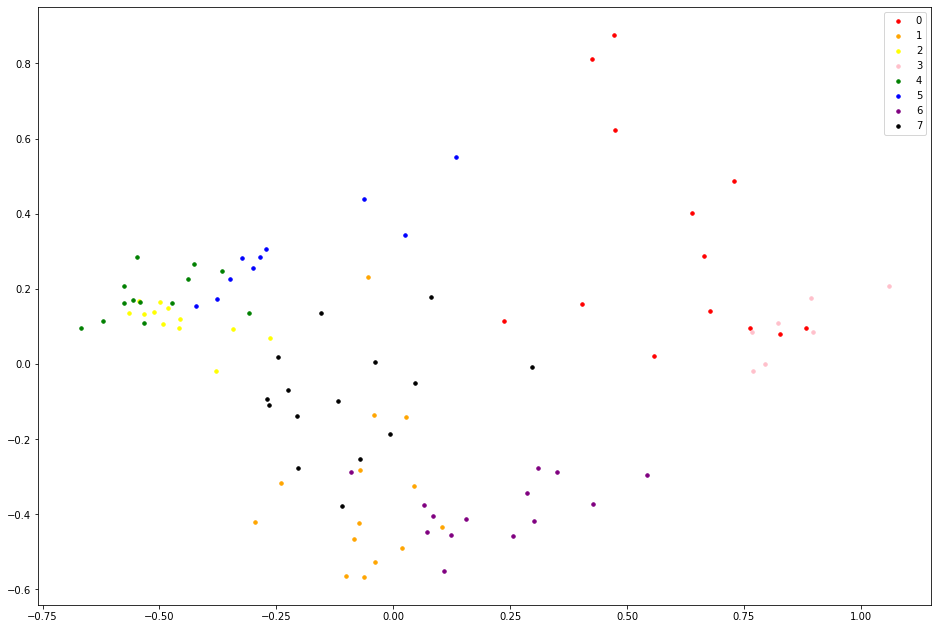

In [165]:
colors = ['red', 'orange', 'yellow', 'pink', 'green', 'blue', 'purple', 'black', 'cyan', 'grey']
fig, ax = plt.subplots(figsize=(16,11))
features_2d = features_2d.sort_values('Cluster')

for cluster_label in features_2d['Cluster'].unique():
    group = features_2d.loc[features_2d['Cluster'] == cluster_label]
    ax.scatter(group['Component 1'], group['Component 2'], c = colors[cluster_label], label=cluster_label, s=12)
    
ax.legend()

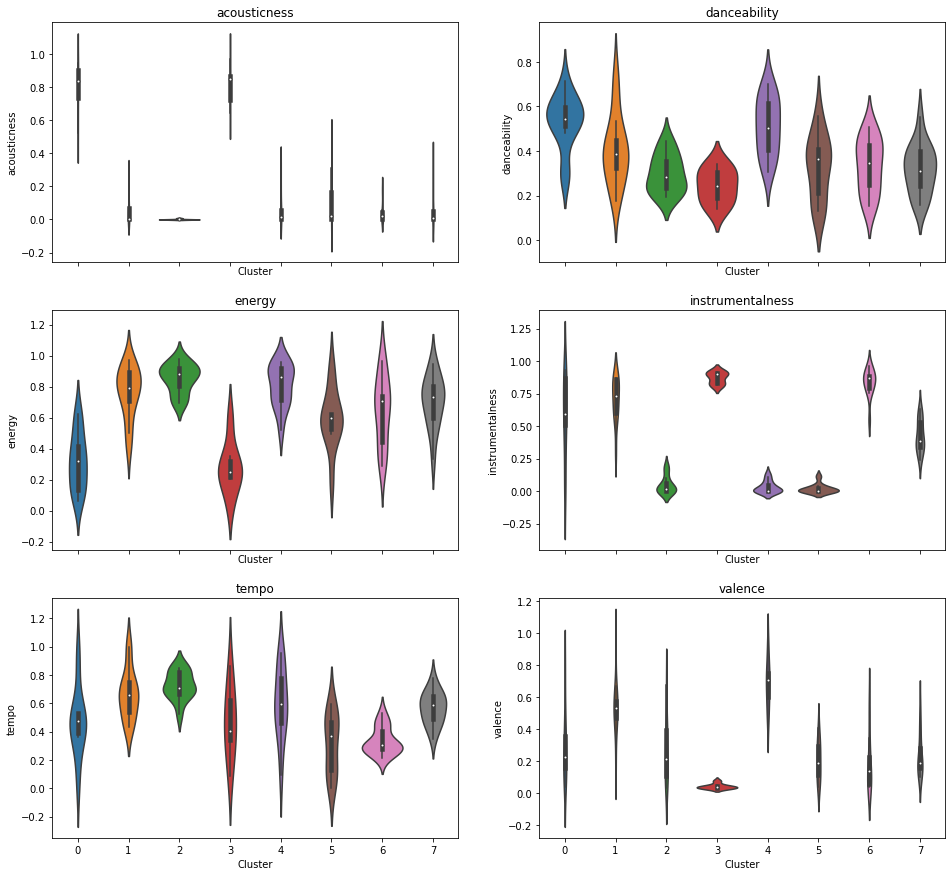

In [120]:
fig, ax = plt.subplots(3, 2, sharex=True, figsize=(16, 15))
ax = ax.flatten()
idx = 0

for col in features.loc[:,:'valence'].columns:
    seaborn.violinplot(features['Cluster'], features[col], ax=ax[idx])
    ax[idx].set_title(col)
    idx += 1

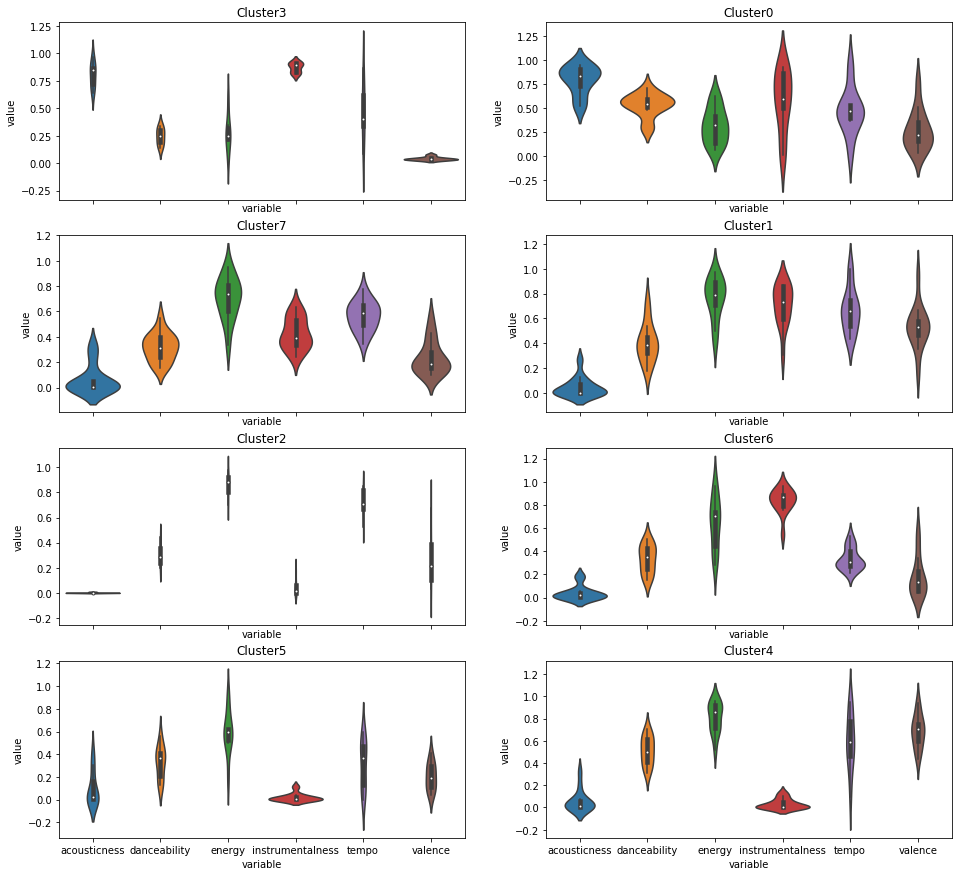

In [256]:
fig, ax = plt.subplots(int((len(clusters.cluster_centers_))/2) + 1, 2, sharex=True, figsize=(16, 15))
ax = ax.flatten()
idx = 0

for cluster_label in features['Cluster'].unique():
    group = features.loc[features['Cluster'] == cluster_label].drop('Cluster', axis=1).melt()
    seaborn.violinplot(x=group['variable'], y=group['value'], data=group, ax=ax[idx])
    ax[idx].set_title("Cluster " + str(cluster_label))
    idx += 1

### Finding Similar Songs

In [215]:
artists = track_info.groupby('artist').count().drop('Cluster', axis=1).reset_index().rename(columns={"title": "count"})
artists = artists.sort_values('count', ascending=False).head(25)
artists['uri'] = [artist_uris[artist] for artist in artists['artist']]
artists.head(5)

,artist,count,uri
39,Unwound,16,spotify:artist:4YjpqCSDD7zwMQgPYJMqb0
28,Pygmy Lush,10,spotify:artist:6CvRYvBXMl9mLpXddexvaL
36,Tigers Jaw,7,spotify:artist:0tLaqkKW7K6tc3QF9SM0M8
4,Bert Love,6,spotify:artist:0Yi3BHFDCJGAE4aS53uBK4
30,Sleepytime Trio,5,spotify:artist:5yFWk36y1daD13Z6XbK32s


In [216]:
related_tracks = []
known_artists = set(track_info['artist'])

for tup in artists.itertuples():
    for artist in sp.artist_related_artists(tup.uri)['artists'][:12]:
        
        if artist['name'] not in known_artists:
            known_artists.add(artist['name'])
            
            for track in sp.artist_top_tracks(artist['uri'])['tracks'][:5]:
                related_tracks.append([track['name'], track['artists'][0]['name'], track['uri']])
    
related_tracks = pd.DataFrame(related_tracks).rename(columns={0: "title", 1: "artist", 2: "uri"})
related_tracks

,title,artist,uri
0,Prayer To God,Shellac,spotify:track:3jAbhqTcpsUxlA4x1suTBz
1,Riding Bikes,Shellac,spotify:track:63EWwR1EjGfeWeEAlv4INs
2,My Black Ass,Shellac,spotify:track:0teei1yQyDihoiOGYsr9rp
3,Dude Incredible,Shellac,spotify:track:23khN5nagSD1qRYYHMJrXo
4,Squirrel Song,Shellac,spotify:track:6EarSYf5t7BodbYWYlP6N7
...,...,...,...
1105,I'm a Dreamer,Josephine Foster,spotify:track:0Gg82ex8NjAl3oNmCk0LTA
1106,Puerto De Santa Maria,Josephine Foster,spotify:track:5u2gzYZgSooUy4ReRcxGbm
1107,Child of God,Josephine Foster,spotify:track:6sO1dtO4c8CQWi0hBWrTTR
1108,Sugar Pie I'm Not the Same,Josephine Foster,spotify:track:3VrNu2PWXzDNx8OJpJr4zU


In [217]:
rec_features = []

for uri in related_tracks['uri']:
    rec_features.extend(sp.audio_features(uri))

rec_features = pd.DataFrame(rec_features)
rec_features = rec_features[['acousticness', 'danceability', 'energy', 'instrumentalness', 'tempo', 'valence']]
rec_features['tempo'] = (rec_features['tempo']-rec_features['tempo'].min())/ \
                        (rec_features['tempo'].max()-rec_features['tempo'].min())
rec_features

retrying ...1secs
retrying ...1secs


,acousticness,danceability,energy,instrumentalness,tempo,valence
0,0.30600,0.475,0.3610,0.000000,0.723327,0.4350
1,0.08420,0.621,0.5210,0.641000,0.596521,0.2410
2,0.00006,0.395,0.6530,0.187000,0.567454,0.9110
3,0.01280,0.345,0.7500,0.537000,0.772561,0.6680
4,0.14900,0.456,0.8130,0.181000,0.840954,0.6950
...,...,...,...,...,...,...
1105,0.94800,0.560,0.0574,0.000023,0.466321,0.1910
1106,0.97800,0.445,0.2790,0.483000,0.590107,0.2490
1107,0.20100,0.648,0.4700,0.000000,0.478726,0.6740
1108,0.87700,0.568,0.2890,0.000501,0.528700,0.4130


In [224]:
rec_features['cluster'] = clusters.predict(rec_features)
rec_features['silhouette'] = metrics.silhouette_samples(rec_features.loc[:'valence'], rec_features['cluster'])
rec_features[['title', 'artist', 'uri']] = related_tracks[['title', 'artist', 'uri']]
rec_features.head(10)

,acousticness,danceability,energy,instrumentalness,tempo,valence,cluster,silhouette,title,artist,uri
0,0.306000,0.475,0.361,0.0000,0.723327,0.4350,5,0.604365,Prayer To God,Shellac,spotify:track:3jAbhqTcpsUxlA4x1suTBz
1,0.084200,0.621,0.521,0.6410,0.596521,0.2410,1,0.568201,Riding Bikes,Shellac,spotify:track:63EWwR1EjGfeWeEAlv4INs
2,0.000060,0.395,0.653,0.1870,0.567454,0.9110,4,0.635367,My Black Ass,Shellac,spotify:track:0teei1yQyDihoiOGYsr9rp
3,0.012800,0.345,0.750,0.5370,0.772561,0.6680,1,0.600108,Dude Incredible,Shellac,spotify:track:23khN5nagSD1qRYYHMJrXo
4,0.149000,0.456,0.813,0.1810,0.840954,0.6950,4,0.651488,Squirrel Song,Shellac,spotify:track:6EarSYf5t7BodbYWYlP6N7
5,0.000232,0.409,0.942,0.2650,0.754861,0.5210,2,0.650341,Luau,Drive Like Jehu,spotify:track:0rcBONdvQcvSHARoEVbfSO
6,0.000013,0.144,0.996,0.8460,0.473876,0.0889,6,0.585825,Here Come the Rome Plows,Drive Like Jehu,spotify:track:2VaZ98xvuFoOwlzqAedqUZ
7,0.001760,0.277,0.706,0.3720,0.667185,0.3890,7,0.650537,Do You Compute,Drive Like Jehu,spotify:track:793RxZVVT5ITET0thwbjAK
8,0.000020,0.335,0.996,0.7710,0.496968,0.1670,6,0.601539,Golden Brown,Drive Like Jehu,spotify:track:74qgrn0YAo3cgRcH4xQBsA
9,0.000012,0.245,0.993,0.7270,0.509032,0.2620,6,0.573826,New Math,Drive Like Jehu,spotify:track:6lSqeJ5a8OS1REwIm5OABR


In [274]:
grouped = rec_features.groupby('cluster').apply(lambda x: x.sort_values('silhouette', ascending=False).head(12))
grouped = grouped.reset_index(drop=True)

grouped.groupby('cluster').mean()['silhouette']

cluster
0    0.601567
1    0.683863
2    0.781890
3    0.823237
4    0.729616
5    0.697972
6    0.674710
7    0.638437
Name: silhouette, dtype: float64

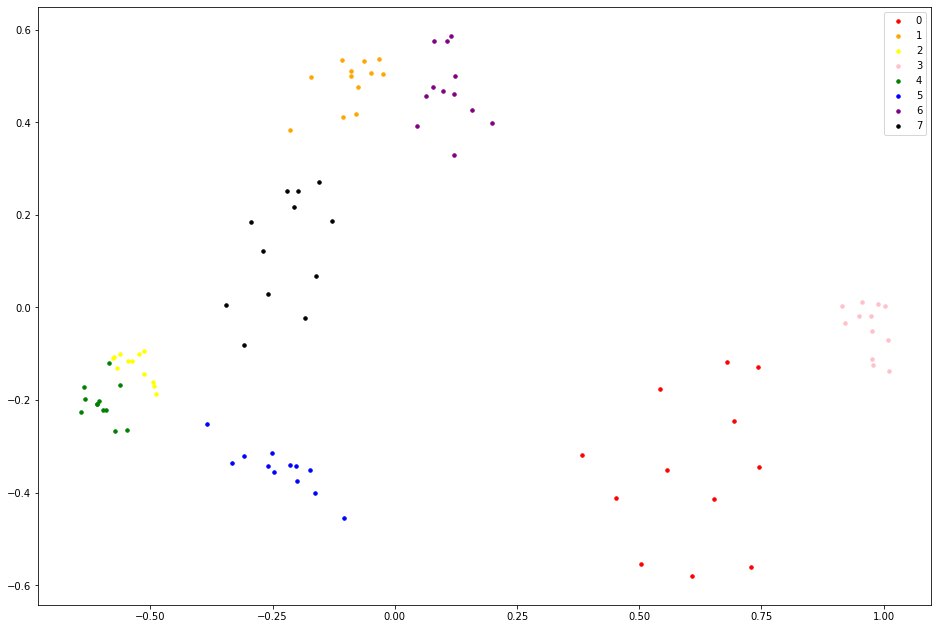

In [275]:
features_2d = pd.DataFrame(pca.fit_transform(grouped.loc[:,:'valence']), columns=['Component 1', 'Component 2'])
features_2d['cluster'] = grouped['cluster'].astype(int)

fig, ax = plt.subplots(figsize=(16,11))
features_2d = features_2d.sort_values('cluster')

for cluster_label in features_2d['cluster'].unique():
    group = features_2d.loc[features_2d['cluster'] == cluster_label]
    ax.scatter(group['Component 1'], group['Component 2'], c = colors[cluster_label], label=cluster_label, s=12)
    
ax.legend()

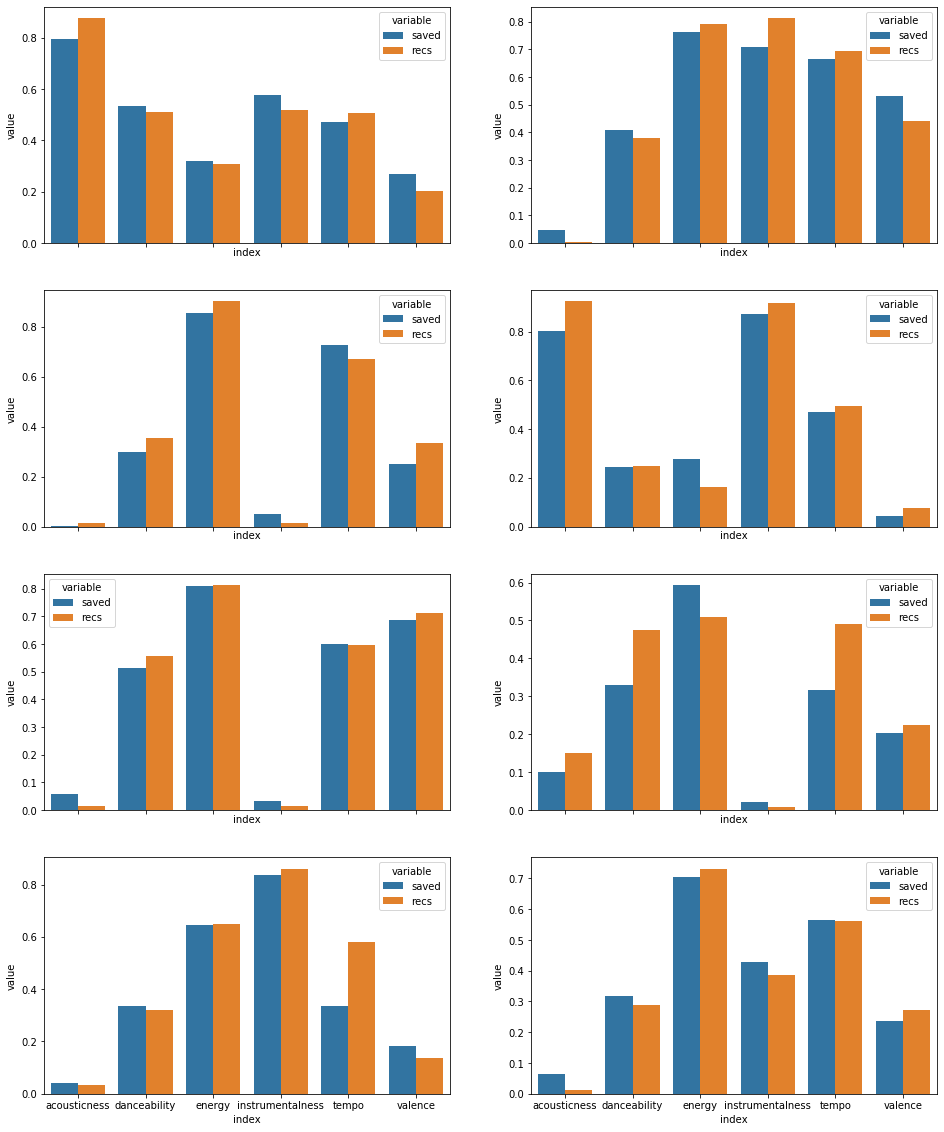

In [327]:
fig, ax = plt.subplots(int((len(clusters.cluster_centers_ + 1))/2), 2, sharex=True, figsize=(16, 20))
ax = ax.flatten()
idx = 0

for cluster_label in grouped['cluster'].unique():
    saved = features.loc[features['Cluster'] == cluster_label].loc[:,:'valence'].mean()
    recs = grouped.loc[grouped['cluster'] == cluster_label].loc[:,:'valence'].mean()

    combined = pd.DataFrame(saved).rename(columns={0: "saved"})
    combined['recs'] = recs
    combined = combined.reset_index().melt(id_vars=['index'])
    seaborn.barplot(x=combined['index'], y=combined['value'], hue=combined['variable'], data=group, ax=ax[idx])
    
    idx += 1

In [244]:
for cluster_label in grouped['cluster'].unique():
    cluster_rec = grouped.loc[grouped['cluster'] == cluster_label]
    feature_avgs = cluster.mean().drop(['cluster', 'silhouette'])
    
    name = ""
    for feature in feature_avgs.keys():
        if feature_avgs[feature] < 0.2:
            name += "Low " + feature + ", "
        elif feature_avgs[feature] > 0.65:
            name += "High " + feature + ", "
    name = name[:-2]
    
    playlist = sp.user_playlist_create('indabasszone', name)
    sp.user_playlist_add_tracks(username, playlist['id'], cluster_rec['uri'])

High acousticness
Low acousticness, High energy, High instrumentalness, High tempo
Low acousticness, High energy, Low instrumentalness, High tempo
High acousticness, Low energy, High instrumentalness, Low valence
Low acousticness, High energy, Low instrumentalness, High valence
Low acousticness, Low instrumentalness
Low acousticness, High instrumentalness, Low valence
Low acousticness, High energy


## Takeaways 